# Import standard libraries

In [418]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import and clean data

In [405]:
#read data file
df=pd.read_pickle("LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [409]:
#filter rows with missing failure type values and no defect
df['failureNum']=df.failureType
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
df=df.replace({'failureNum':mapping_type})
df=df[(df['failureNum']>=0) & (df['failureNum']<8)]
df= df[df.failureNum != '']
df.reset_index(drop=True, inplace=True)
df.head()


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,failureNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],[[Loc]],4
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],[[Edge-Loc]],2
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],[[Edge-Loc]],2
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],[[Edge-Loc]],2
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],[[Edge-Loc]],2


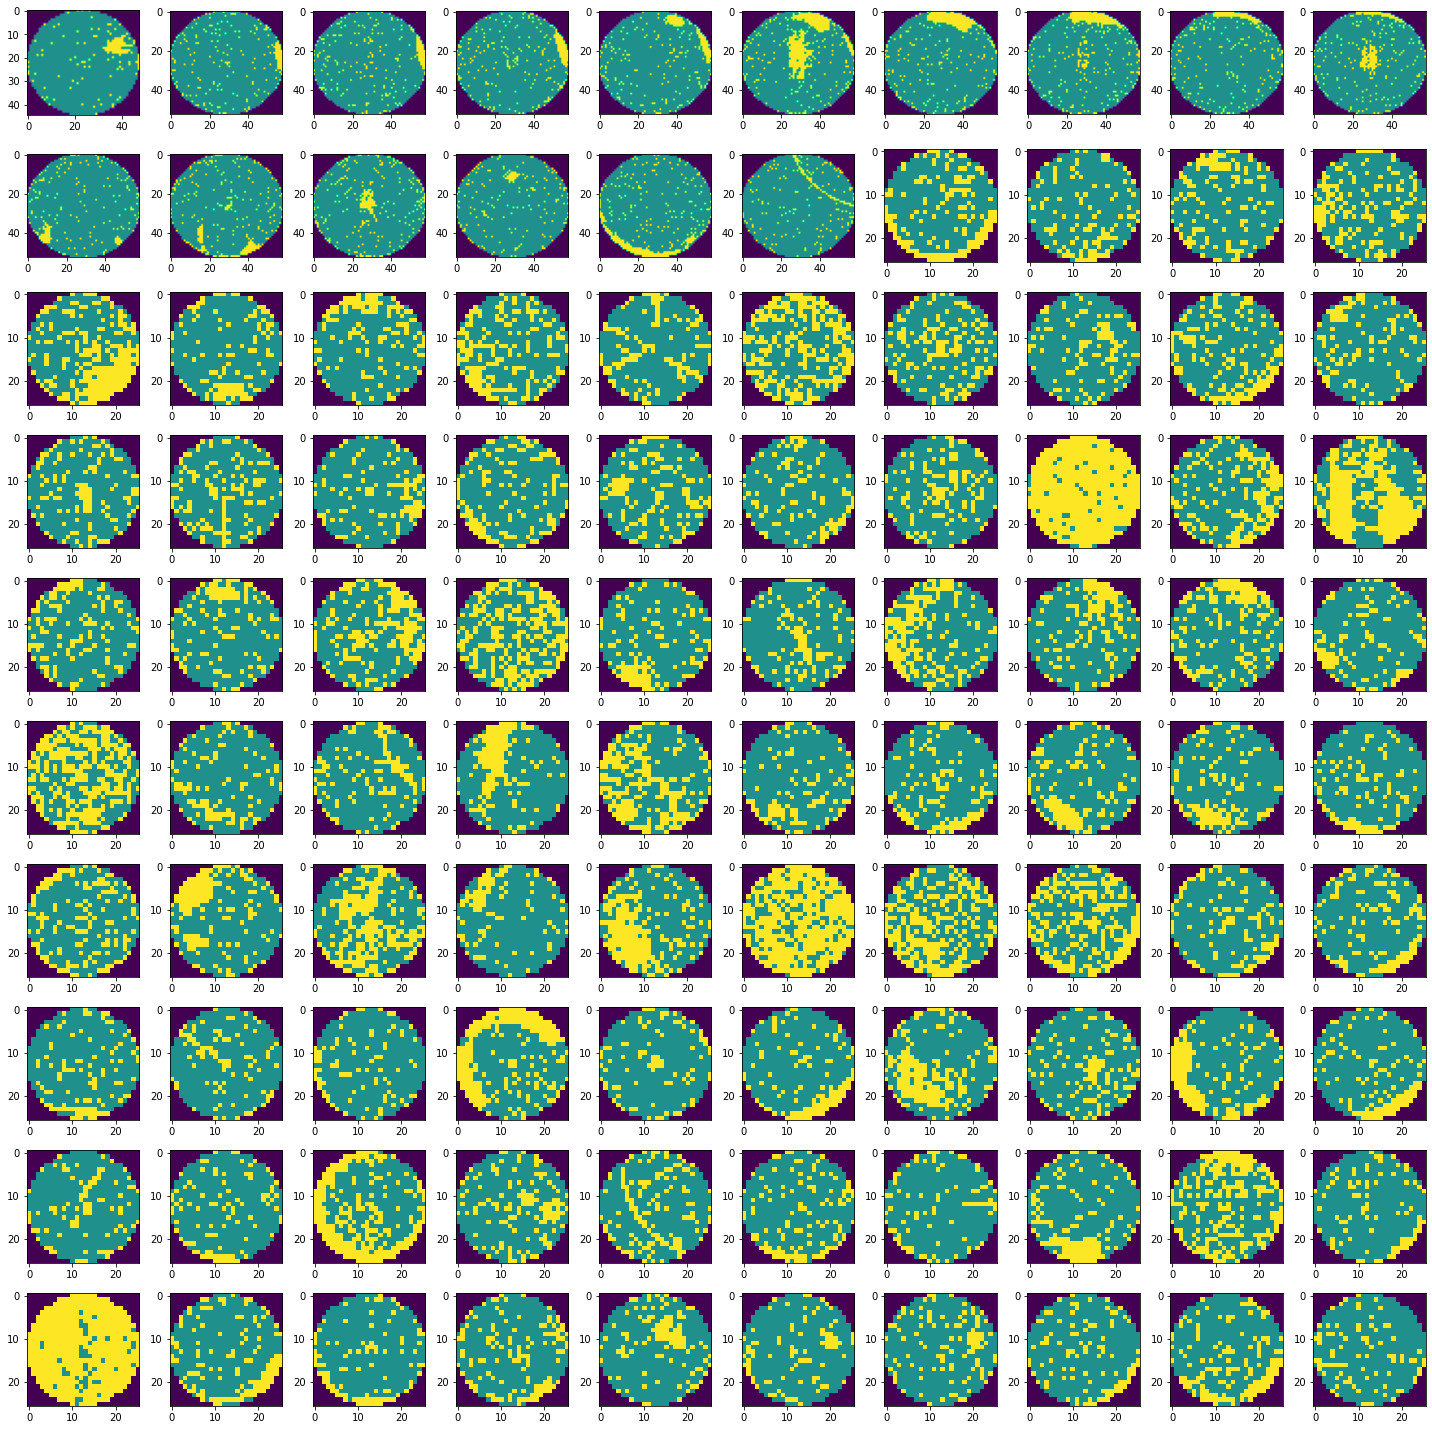

In [411]:
#check some images
images = df.waferMap

fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.flatten()
for i in range(100):
    img = images[i]
    ax[i].imshow(img)
plt.tight_layout()
plt.show() 

In [431]:
#image sizes are not same and are given as 2 dimensional arrays. For resnet architecture they need to be in rgb format. 
# Let image size be 32, 32, 3
list_im = []
for i in range(len(images)):
    image_3d = np.zeros((np.append(np.shape(images[i]),3)))
    for j in range(np.size(images[i],0)):
        for k in range(np.size(images[i],1)):
            if images[i][j,k] == 2:
                image_3d[j,k,0] = 1
            elif images[i][j,k] == 1:
                image_3d[j,k,1] = 1
    
    list_im.append(image_3d)
    
images2= np.zeros((len(list_im),32,32,3))
for i in range(len(list_im)):
    images2[i,:,:,:]= tf.image.resize(list_im[i], [32,32])
print(np.shape(images2))

(25519, 32, 32, 3)


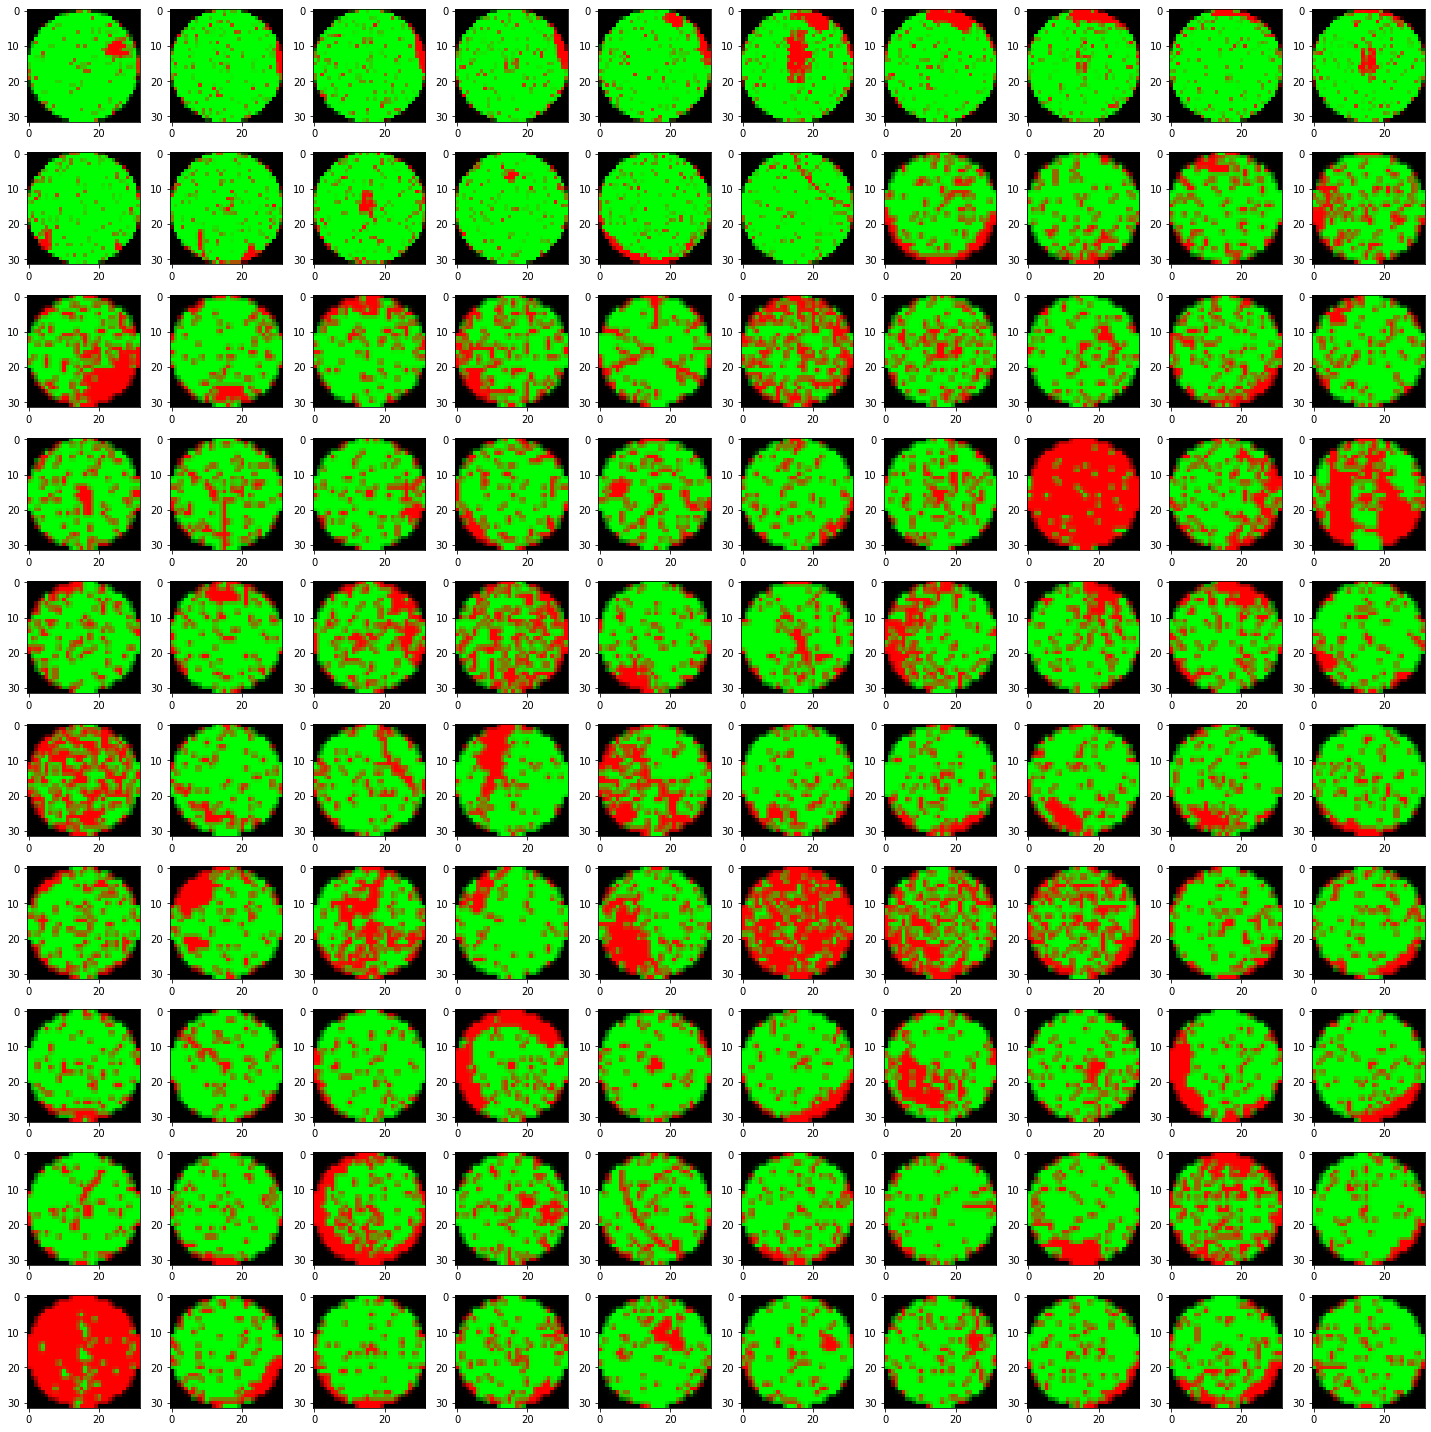

In [416]:
# let's plot images again

fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.flatten()
for i in range(100):
    img = images2[i]
    ax[i].imshow(img)
plt.tight_layout()
plt.show() 

In [433]:
#Split data into train and test sets
from sklearn.model_selection import train_test_split

y =df1.failureNum[0:len(images2)].to_numpy(dtype=float)

#y_train = tf.convert_to_tensor(y_train)
X_train, X_test, y_train, y_test = train_test_split(images2, y, test_size = 0.2, random_state = 0)

# Build CNN

In [2]:
tf.__version__

'2.3.0'

In [377]:
# Here we will use resnet50 architecture with precomputed imagenet coefficients and removed dense layers as a starting point 
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
baseModel = ResNet50(weights='imagenet',include_top=False,input_tensor=tf.keras.Input(shape=(32, 32, 3)))

#baseModel.summary()




In [378]:
# add pooling and dense layers on top of resnet50
headModel = baseModel.output
headModel = tf.keras.layers.AveragePooling2D(pool_size=(1, 1))(headModel)
headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
headModel = tf.keras.layers.Dense(1024, activation="relu")(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(8, activation="softmax")(headModel)

model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)
#model.summary()

In [379]:
#compile model    
model.compile(loss="sparse_categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])

In [392]:
#train model
y_train = tf.convert_to_tensor(y_train)
history = model.fit(X_train, y_train, batch_size = 128, epochs = 30, verbose = 1)

Epoch 1/30
160/160 [==============================] - 392s 2s/step - loss: 0.2576 - accuracy: 0.9055
Epoch 2/30
160/160 [==============================] - 383s 2s/step - loss: 0.1880 - accuracy: 0.9340
Epoch 3/30
160/160 [==============================] - 386s 2s/step - loss: 0.1531 - accuracy: 0.9435
Epoch 4/30
160/160 [==============================] - 388s 2s/step - loss: 0.1342 - accuracy: 0.9520
Epoch 5/30
160/160 [==============================] - 384s 2s/step - loss: 0.1180 - accuracy: 0.9586
Epoch 6/30
160/160 [==============================] - 385s 2s/step - loss: 0.1000 - accuracy: 0.9655
Epoch 7/30
160/160 [==============================] - 385s 2s/step - loss: 0.0880 - accuracy: 0.9689
Epoch 8/30
160/160 [==============================] - 389s 2s/step - loss: 0.0862 - accuracy: 0.9697
Epoch 9/30
160/160 [==============================] - 383s 2s/step - loss: 0.0777 - accuracy: 0.9729
Epoch 10/30
160/160 [==============================] - 384s 2s/step - loss: 0.0792 - accura

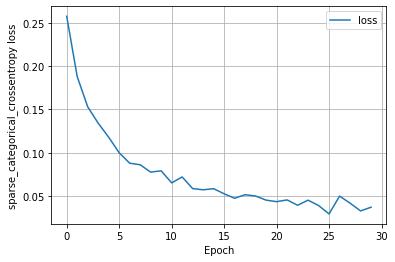

In [420]:
#plot loss curve
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('sparse_categorical_crossentropy loss')
plt.legend()
plt.grid(True)
plt.show()

# Test model

In [434]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
#print(np.count_nonzero(np.argmax(y_pred, axis=1)-y_test))
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

from sklearn.metrics import confusion_matrix, accuracy_score
print(accuracy_score(y_test,y_pred))
confusion_matrix(y_test, y_pred)

0.9188871473354232


array([[ 864,    1,    0,    1,   21,    0,   11,    0],
       [   2,   95,    1,    0,   12,    0,    1,    0],
       [   3,    0,  908,   32,   54,    0,   26,    0],
       [   3,    0,   27, 1879,    4,    0,    2,    0],
       [  17,    7,   53,    0,  584,    1,   60,    0],
       [   4,    2,    7,    1,    9,  155,    2,    3],
       [   0,    0,   10,    0,   35,    0,  174,    0],
       [   1,    0,    1,    0,    0,    0,    0,   31]], dtype=int64)